# Clustering of DFKI RIC's Publications

## Preparation

You have to install the following additional packages:
* [NLTK](https://pypi.org/project/nltk/)
* [scikit-learn](https://pypi.org/project/scikit-learn/)

In [1]:
%pylab inline
import json
import nltk
from nltk.stem import PorterStemmer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances

Populating the interactive namespace from numpy and matplotlib


We download some data for NLTK:

In [2]:
nltk.download("punkt")  # stemming
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/dfki.uni-
[nltk_data]     bremen.de/afabisch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dfki.uni-
[nltk_data]     bremen.de/afabisch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

What are stopwords? - https://en.wikipedia.org/wiki/Stop_word

In [3]:
stopwords = nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("german")
#" ".join(stopwords)

## Dataset

The following dataset contains a list of all publications of DFKI RIC obtained from our website: https://robotik.dfki-bremen.de/en/research/publications

In [4]:
with open("publication_database.json", "r") as f:
    publications = json.load(f)

In [5]:
len(publications)

967

## Preprocessing

This code is given because it requires domain knowledge and needs NLTK, a package that you are most likely not familiar with.

We do the following:

1. tokenize
2. stemming - https://en.wikipedia.org/wiki/Stemming
3. filter stopwords
4. apply vectorizer (TF-IDF) - https://en.wikipedia.org/wiki/Tf%E2%80%93idf

The last part is particularly important, as it translates a list of strings to a vector of fixed length, which we can use in machine learning.

In [6]:
class StemStopwordTfidf:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(input="content", max_df=0.5)
        self.ps = PorterStemmer()

    def fit_transform(self, X):
        X = [self._preprocess_text(sample) for sample in X]
        features = self.vectorizer.fit_transform(X)
        return features

    def transform(self, X):
        X = [self._preprocess_text(sample) for sample in X]
        features = self.vectorizer.transform(X)
        return features

    def _preprocess_text(self, text):
        words = nltk.word_tokenize(text)
        words = [self.ps.stem(w) for w in words]
        words = [w for w in words if w not in stopwords]
        return " ".join(words)

In [7]:
def compute_features_tfidf(publications):
    data = [p["title"] + " " + p["abstract"] for p in publications]
    model = StemStopwordTfidf()
    features = model.fit_transform(data)
    return model, features

In [8]:
feature_generator, X = compute_features_tfidf(publications)

## k-Means Clustering

**Task:** Run k-means on the dataset.

In [9]:
cluster = KMeans(n_clusters=12, n_init="auto", random_state=0)
clusters = cluster.fit_predict(X)

## Evaluation of Clusters

**Task:** Select an appropriate metric to evaluate the clustering result from scikit-learn. Try several values for $k$ and evaluate the result. Also check the size of the smallest cluster.

[API docs: clustering metrics](https://scikit-learn.org/stable/modules/classes.html#clustering-metrics)

In [10]:
from sklearn.metrics import calinski_harabasz_score as score_function
#from sklearn.metrics import silhouette_score as score_function
#from sklearn.metrics import davies_bouldin_score as score_function
numbers = []
scores = []
min_cluster_sizes = []
for n_clusters in range(4, 30, 3):
    cluster = KMeans(n_clusters=n_clusters, n_init="auto", random_state=0)
    clusters = cluster.fit_predict(X)
    score = score_function(X.toarray(), clusters)
    numbers.append(n_clusters)
    scores.append(score)
    min_cluster_sizes.append(min(np.unique(clusters, return_counts=True)[1]))

Text(0, 0.5, 'Minimum cluster size')

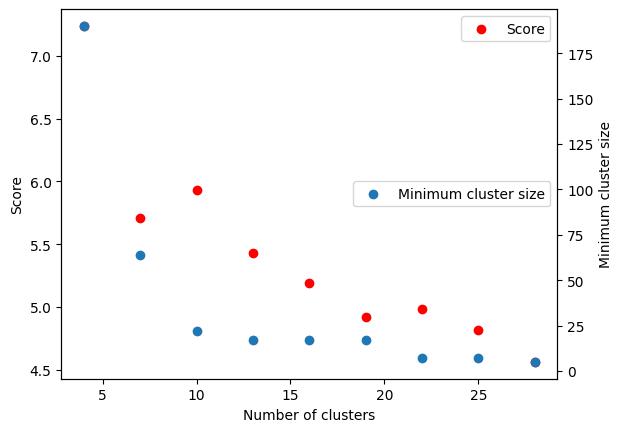

In [11]:
ax = plt.subplot(111)
ax.scatter(numbers, scores, c="r", label="Score")
ax.legend(loc="upper right")
ax.set_ylabel("Score")
ax.set_xlabel("Number of clusters")
ax2 = ax.twinx()
ax2.scatter(numbers, min_cluster_sizes, label="Minimum cluster size")
ax2.legend(loc="center right")
ax2.set_ylabel("Minimum cluster size")

**Task:** Run k-means again with a reasonable number of clusters $k$.

In [12]:
cluster = KMeans(n_clusters=17, n_init="auto", random_state=0)
clusters = cluster.fit_predict(X)

**Task:** Print a summary of each cluster. You could list the most frequent words, print the number of samples, show the samples closest to the center, etc.

In [13]:
cluster_indices, cluster_sizes = np.unique(clusters, return_counts=True)
terms = feature_generator.vectorizer.get_feature_names_out()
cluster_similarities = pairwise_distances(cluster.cluster_centers_, X)
for idx, i in enumerate(cluster_indices):
    print(f"Cluster {i} (n={cluster_sizes[idx]})")
    center = cluster.cluster_centers_[idx]
    order = np.argsort(center)[::-1]
    print(f"\tMost frequent words: {' '.join([terms[term_idx] for term_idx in order[:10]])}")
    print()
    sample_indices = np.argsort(cluster_similarities[i])
    for pub_idx, j in enumerate(sample_indices[:3]):
        print(f"\t{pub_idx + 1}.", end=" ")
        print(f"Title: {publications[j]['title']}")
        print(f"\t   Author: {publications[j]['authors'][0]} et al.")
        print(f"\t   URL: {publications[j]['url']}")
        #print(publications[j])
    print()

Cluster 0 (n=19)
	Most frequent words: control joint behavior bldc motion motor simul complex paramet actuat

	1. Title: An Experience-Based Interface for Abstracting the Motion Control of Kinematically Complex Robots
	   Author: Alexander Dettmann et al.
	   URL: https://robotik.dfki-bremen.de/en/research/publications/8530
	2. Title: An Experience-Based Interface for Abstracting the Motion Control of Kinematically Complex Robots
	   Author: Alexander Dettmann et al.
	   URL: https://robotik.dfki-bremen.de/en/research/publications/7901
	3. Title: Experience-Based Adaptation of Locomotion Behaviors for Kinematically Complex Robots in Unstructured Terrain
	   Author: Alexander Dettmann et al.
	   URL: https://robotik.dfki-bremen.de/en/research/publications/7900

Cluster 1 (n=67)
	Most frequent words: explor lunar mission crater space rover project cooper multi team

	1. Title: Heterogeneous Robotic Teams for Exploration of Steep Crater Environments
	   Author: Florian Cordes et al.
	   U

**Task:** Visualize clusters. Since the data is high-dimensional, you have to project the samples to 2D first. You can use [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) for this purpose, which is similar to PCA, but works very well for sparse, high-dimensional data.

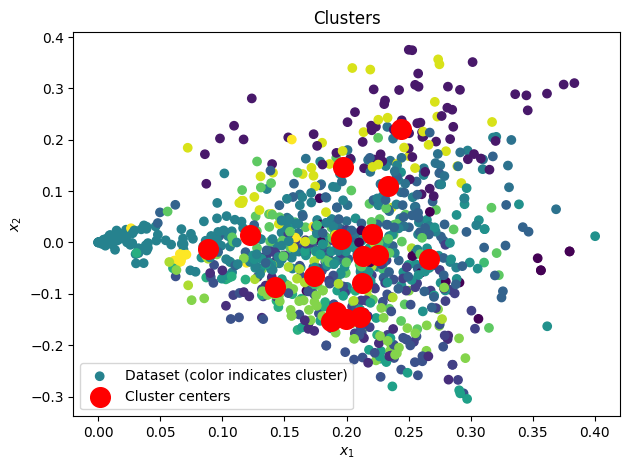

In [14]:
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)
centers_svd = svd.transform(cluster.cluster_centers_)
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=clusters, label="Dataset (color indicates cluster)")
plt.scatter(centers_svd[:, 0], centers_svd[:, 1], c="r", label="Cluster centers", s=200)
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Clusters")
plt.tight_layout()
plt.show()